In [43]:
import warnings
warnings.filterwarnings("ignore")
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

In [44]:
df = pd.read_csv("reviews.csv")

In [45]:
df.isnull().sum()

company               0
rating                0
title                14
pros                  0
cons                  0
reviewer_title        0
reviewer_location     0
datetime              0
is_current_job        0
dtype: int64

In [46]:
import spacy
nlp = spacy.load('en_core_web_sm')

#additional stopwords based on the words above
nlp.Defaults.stop_words |= {"work", "review", "reviews"}

spacy_stopwords = nlp.Defaults.stop_words

In [47]:
def clean_text(text):
    if isinstance(text, str):
        doc = nlp(text)  # Tokenize the text using spaCy
        cleaned_tokens = []
        for token in doc:
            if token.is_stop or token.is_punct or not token.is_alpha:
                continue
            cleaned_tokens.append(token.lemma_.lower())  # Lemmatize and convert to lowercase
        cleaned_text = ' '.join(cleaned_tokens)  # Join the cleaned tokens back into a string
        return cleaned_text
    else:
        return ''

In [48]:
df['title'] = df['title'].apply(clean_text)
df['pros'] = df['pros'].apply(clean_text)
df['cons'] = df['pros'].apply(clean_text)

In [49]:
df.isnull().sum()

company              0
rating               0
title                0
pros                 0
cons                 0
reviewer_title       0
reviewer_location    0
datetime             0
is_current_job       0
dtype: int64

In [50]:
#replacing certain terms with NIL
df.replace(r'^\s*$', 'nil', regex=True, inplace=True)
df.replace('xxxx', 'nil', inplace=True)
df.replace('na', 'nil', inplace=True)

In [51]:
#drop irrelevant columns
df.drop(['reviewer_location', 'datetime', 'is_current_job'], axis=1, inplace=True)


In [52]:
def title_simplifier1(title):
    if ('data analyst' in title.lower() or 'data analytics' in title.lower() or 'product analyst' in title.lower()
    or 'supplychain' in title.lower() or 'pricing' in title.lower() or 'data entry analysis' in title.lower() 
    or 'system analyst' in title.lower() or 'business analysis' in title.lower() 
    or 'analyst' in title.lower() or 'associate' in title.lower()
    or 'research' in title.lower() or 'research fellows' in title.lower()
    or 'machine learning' in title.lower() or 'ai' in title.lower()
    or 'business intelligence' in title.lower() or 'bie' in title.lower() or 'insights' in title.lower() or 'visualization' in title.lower()
    or 'consultant' in title.lower()
    or 'business analyst' in title.lower() or 'owner' in title.lower() or 'product' in title.lower() or 'digital' in title.lower()
    or 'data management' in title.lower() or 'governance' in title.lower() or 'data administrator' in title.lower()
    or 'quantitative' in title.lower() or 'quant' in title.lower()
    or 'finance' in title.lower() or 'fintech' in title.lower() or 'blockchain' in title.lower() or 'financial' in title.lower()
    or 'intern' in title.lower() or 'internship' in title.lower()
    or 'statistician' in title.lower()
    or 'solution architect' in title.lower() or 'solutions architect' in title.lower()
    or 'data science analyst' in title.lower() or 'scientist' in title.lower() or 'data science' in title.lower()):
        return 'Data roles'

    if ('analytics manager' in title.lower() or 'senior manager' in title.lower() or 'director' in title.lower() or 'vp' in title.lower() or 'avp' in title.lower()
    or 'technical lead' in title.lower() or 'lead' in title.lower()
    or 'it manager' in title.lower() or 'engineering manager' in title.lower() or 'technology manager' in title.lower() or 'manager' in title.lower()
    or 'scrum master' in title.lower() or 'scrum' in title.lower() or 'agility' in title.lower()):
        return 'Leadership roles'
    
    if ('computer vision' in title.lower() or 'cv' in title.lower() or 'natural language processing' in title.lower() or 'nlp' in title.lower() or 'text analytics' in title.lower() or 'artificial intelligence' in title.lower() or 'ai' in title.lower() or 'rpa' in title.lower()
    or 'software engineer' in title.lower() or 'software developer' in title.lower() or 'software' in title.lower() or 'application developer' in title.lower() or 'applications developer' in title.lower() or 'app' in title.lower() or 'applications' in title.lower() or 'developer support' in title.lower() or 'game' in title.lower() or 'software' in title.lower() or 'android' in title.lower() or 'mobile' in title.lower()
    or 'full-stack' in title.lower() or 'fullstack' in title.lower() or 'full stack' in title.lower() or 'platform developer' in title.lower() or 'web application' in title.lower() or 'datacap' in title.lower() or 'java developer' in title.lower() or 'summit' in title.lower() or 'web api' in title.lower() or 'net' in title.lower() or 'summit' in title.lower() or 'javascript' in title.lower() or 'c++' in title.lower() or 'c/c++' in title.lower()
    or 'front-end' in title.lower() or 'frontend' in title.lower() or 'front end' in title.lower() or 'web developer' in title.lower()
    or 'back-end' in title.lower() or 'backend' in title.lower() or 'back end' in title.lower()
    or 'data developer' in title.lower() or 'data scientist' in title.lower() 
    or 'devops' in title.lower() or 'dev ops' in title.lower() or 'devopssecops' in title.lower() or 'devops/secops' in title.lower() or 'devsecops' in title.lower() or 'ops' in title.lower()
    or 'cloud developer' in title.lower() or 'cloud' in title.lower() or 'aqua' in title.lower() or 'big data' in title.lower()
    or 'ui' in title.lower() or 'ux' in title.lower()):
        return 'Developer roles'
    
    if ('quality assurance engineer' in title.lower() or 'quality' in title.lower()
    or 'data engineer' in title.lower() or 'data engineering' in title.lower() or 'support engineer' in title.lower() or 'data architect' in title.lower()
    or 'cyber' in title.lower() or 'cyber security' in title.lower() or 'cybersecurity' in title.lower() or 'infosecurity' in title.lower() or 'threat' in title.lower() or 'security' in title.lower()
    or 'systems engineer' in title.lower() or 'system engineer' in title.lower() or 'pega' in title.lower() or 'system administrator' in title.lower() or 'system' in title.lower() or 'systems' in title.lower() or 'automation' in title.lower() or 'it engineer' in title.lower()
    or 'technical support' in title.lower() or 'it support' in title.lower()
    or 'network engineer' in title.lower() or 'network' in title.lower() or 'noc' in title.lower()
    or 'test automation engineer' in title.lower() or 'testing' in title.lower()
    or 'infrastructure' in title.lower() or 'site reliability' in title.lower() or 'operations engineer' in title.lower()
    or 'database' in title.lower() or 'SQL developer' in title.lower() or 'data centre' in title.lower() or 'data platform' in title.lower()
    or 'quality' in title.lower() or 'qa' in title.lower() or 'qc' in title.lower() or 'qaqc' in title.lower()
    or 'performance engineer' in title.lower()):
        return 'Engineer roles'    
        
    else:
        return 'NA'

In [53]:
df['title_simp'] = df['reviewer_title'].apply(title_simplifier1)
job_counts = df['title_simp'].value_counts()
print(job_counts)
job_counts.info()

title_simp
Data roles          774
Developer roles     650
NA                  632
Leadership roles    332
Engineer roles      142
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 5 entries, Data roles to Engineer roles
Series name: count
Non-Null Count  Dtype
--------------  -----
5 non-null      int64
dtypes: int64(1)
memory usage: 80.0+ bytes


In [54]:
#drop irrelevant rows
cleaned_df = df[df['title_simp'] != 'NA']
cleaned_job_counts = cleaned_df['title_simp'].value_counts()
print(cleaned_job_counts)
cleaned_job_counts.info()

title_simp
Data roles          774
Developer roles     650
Leadership roles    332
Engineer roles      142
Name: count, dtype: int64
<class 'pandas.core.series.Series'>
Index: 4 entries, Data roles to Engineer roles
Series name: count
Non-Null Count  Dtype
--------------  -----
4 non-null      int64
dtypes: int64(1)
memory usage: 64.0+ bytes


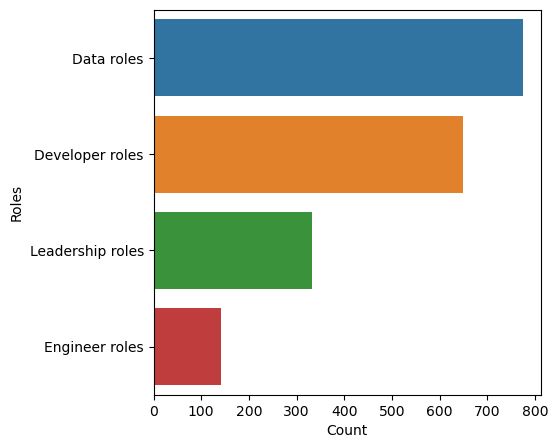

In [55]:
plt.figure(figsize=(5,5)) 
ax = sns.barplot(x=cleaned_job_counts, y=cleaned_job_counts.index) 
ax.set(ylabel = 'Roles', xlabel = 'Count') 
plt.show()

### Reviews Title

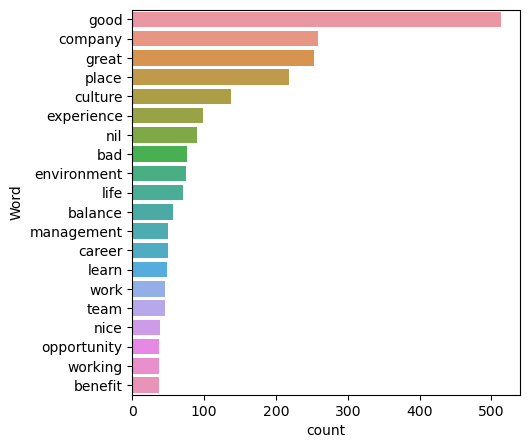

In [56]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(cleaned_df['title'], 20)


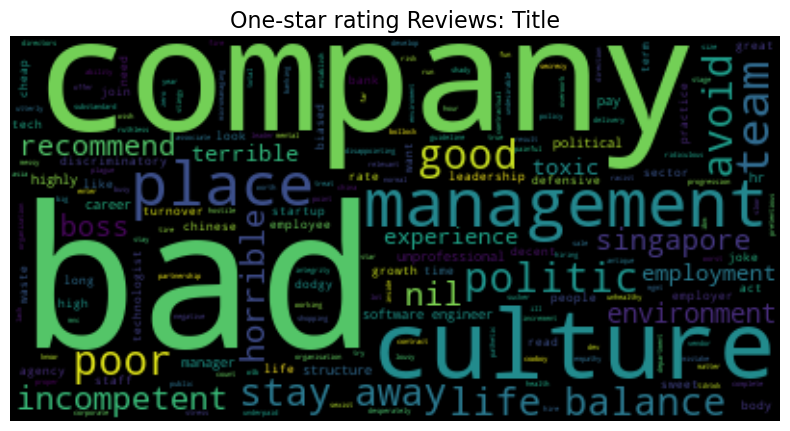

In [57]:
# Filter the rows where the rating is 1 and select the 'title' column
onestar_title = cleaned_df.loc[cleaned_df['rating'] == 1, 'title']

# Concatenate all the titles into a single string
onestar_text_title = ' '.join(onestar_title.astype(str))

# Create the word cloud object
wordcloud_onestar_title = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_text_title)

# Set the title for the word cloud
title = "One-star rating Reviews: Title"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_title, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

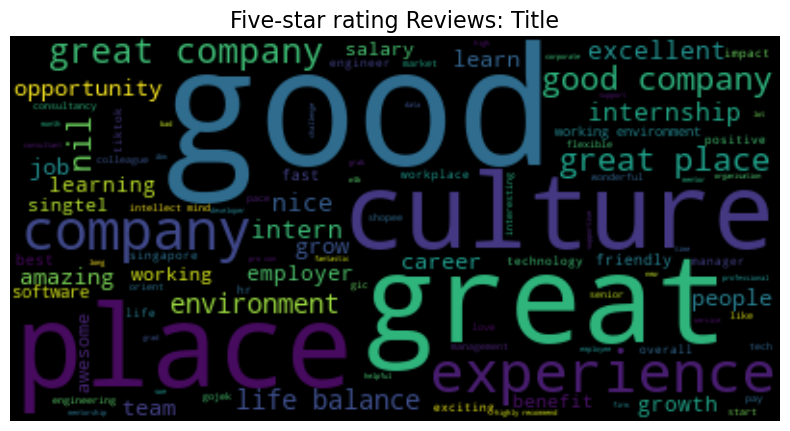

In [58]:
# Filter the rows where the rating is 5 and select the 'title' column
fivestar_title = cleaned_df.loc[cleaned_df['rating'] == 5, 'title']

# Concatenate all the titles into a single string
fivestar_text_title = ' '.join(fivestar_title.astype(str))

# Create the word cloud object
wordcloud_fivestar_title = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_text_title)

# Set the title for the word cloud
title = "Five-star rating Reviews: Title"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_title, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

## Reviews Pros

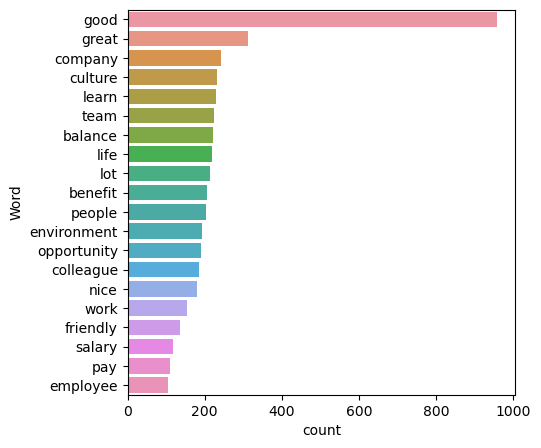

In [59]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(cleaned_df['pros'], 20)

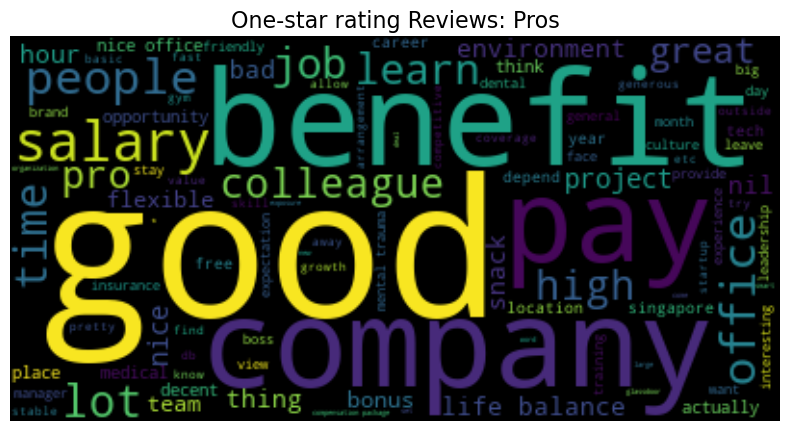

In [60]:
# Filter the rows where the rating is 1 and select the 'pros' column
onestar_pros = cleaned_df.loc[cleaned_df['rating'] == 1, 'pros']

# Concatenate all the pros into a single string
onestar_text_pros = ' '.join(onestar_pros.astype(str))

# Create the word cloud object
wordcloud_onestar_pros = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_text_pros)

# Set the title for the word cloud
title = "One-star rating Reviews: Pros"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_pros, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

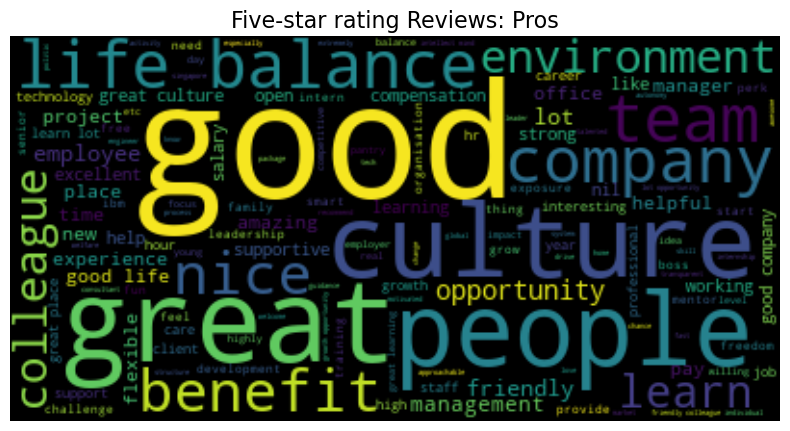

In [61]:
# Filter the rows where the rating is 5 and select the 'pros' column
fivestar_pros = cleaned_df.loc[cleaned_df['rating'] == 5, 'pros']

# Concatenate all the pros into a single string
fivestar_text_pros = ' '.join(fivestar_pros.astype(str))

# Create the word cloud object
wordcloud_fivestar_pros = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_text_pros)

# Set the title for the word cloud
title = "Five-star rating Reviews: Pros"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_pros, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

## Reviews Cons

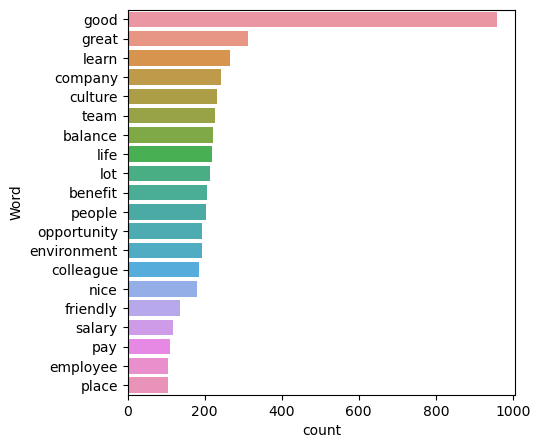

In [62]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(cleaned_df['cons'], 20)

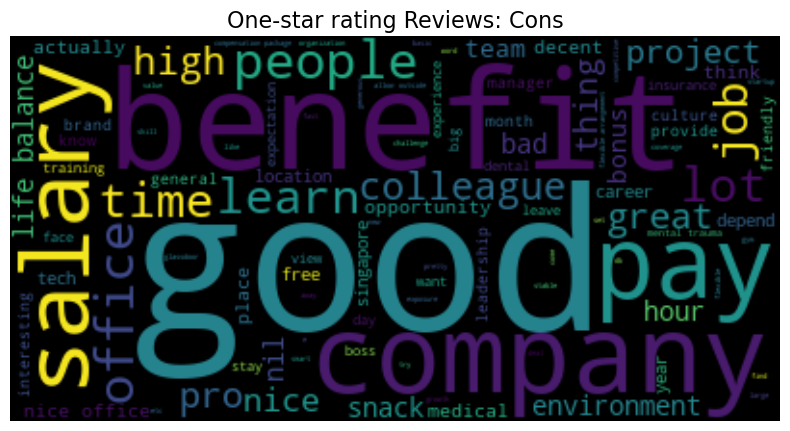

In [63]:
# Filter the rows where the rating is 1 and select the 'cons' column
onestar_cons = cleaned_df.loc[cleaned_df['rating'] == 1, 'cons']

# Concatenate all the pros into a single string
onestar_text_cons = ' '.join(onestar_cons.astype(str))

# Create the word cloud object
wordcloud_onestar_cons = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_text_cons)

# Set the title for the word cloud
title = "One-star rating Reviews: Cons"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_cons, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

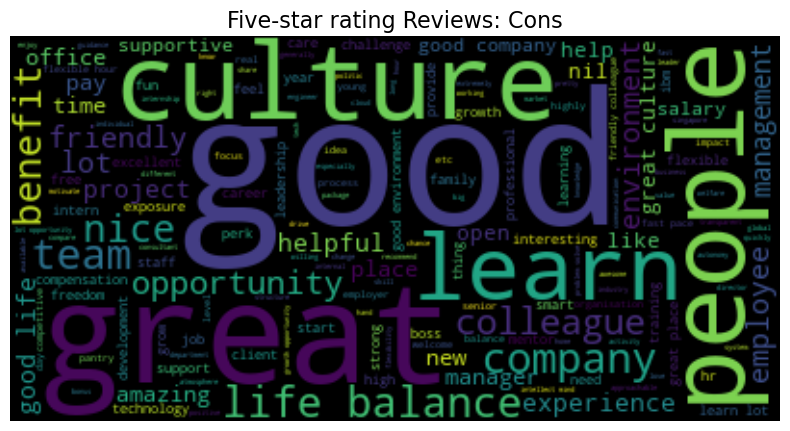

In [64]:
# Filter the rows where the rating is 1 and select the 'cons' column
fivestar_cons = cleaned_df.loc[cleaned_df['rating'] == 5, 'cons']

# Concatenate all the pros into a single string
fivestar_text_cons = ' '.join(fivestar_cons.astype(str))

# Create the word cloud object
wordcloud_fivestar_cons = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_text_cons)

# Set the title for the word cloud
title = "Five-star rating Reviews: Cons"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_cons, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

In [65]:
# Combine the text columns into a single column
cleaned_df['all_text'] = cleaned_df[['title', 'pros', 'cons']].apply(lambda x: ' '.join(map(str, x)), axis=1)

# Filter the DataFrame based on the "title_simp" column
data_df = cleaned_df[cleaned_df['title_simp'] == 'Data roles']
developer_df = cleaned_df[cleaned_df['title_simp'] == 'Developer roles']
leadership_df = cleaned_df[cleaned_df['title_simp'] == 'Leadership roles']
engineer_df = cleaned_df[cleaned_df['title_simp'] == 'Engineer roles']


### For all roles

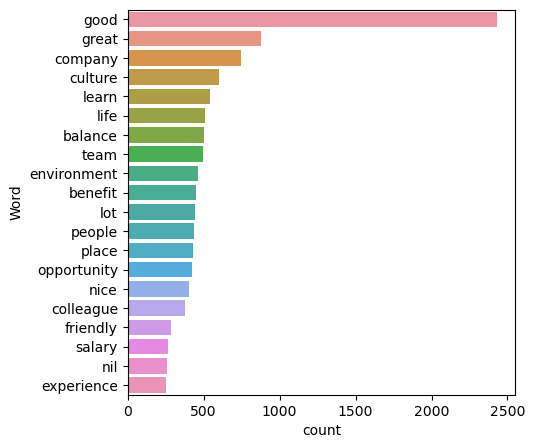

In [66]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(cleaned_df['all_text'], 20)

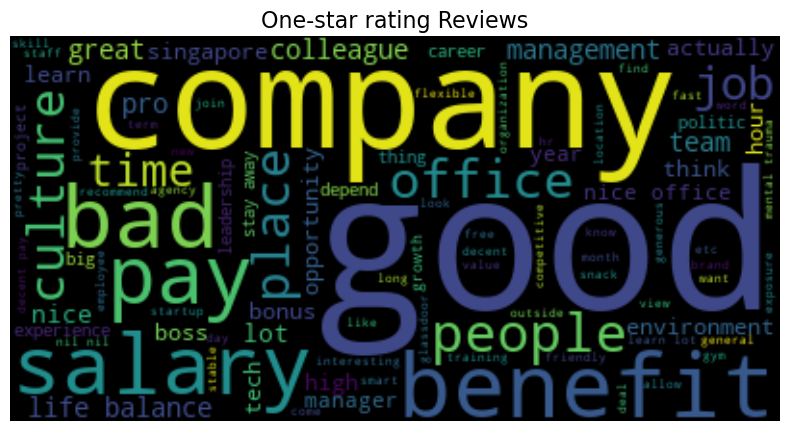

In [67]:
# Filter the rows where the rating is 1 and select the 'all_text' column
onestar_alltext = cleaned_df.loc[cleaned_df['rating'] == 1, 'all_text']

# Concatenate all the pros into a single string
onestar_alltext = ' '.join(onestar_alltext.astype(str))

# Create the word cloud object
wordcloud_onestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_alltext)

# Set the title for the word cloud
title = "One-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

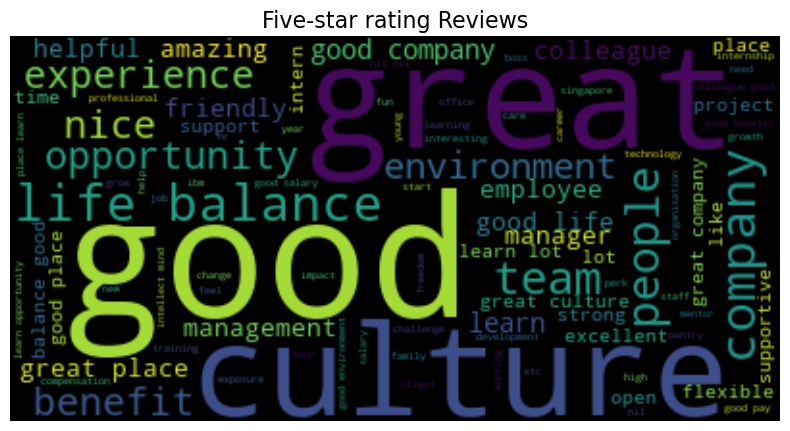

In [68]:
# Filter the rows where the rating is 1 and select the 'all_text' column
fivestar_alltext = cleaned_df.loc[cleaned_df['rating'] == 5, 'all_text']

# Concatenate all the pros into a single string
fivestar_alltext = ' '.join(fivestar_alltext.astype(str))

# Create the word cloud object
wordcloud_fivestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_alltext)

# Set the title for the word cloud
title = "Five-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

### For data roles

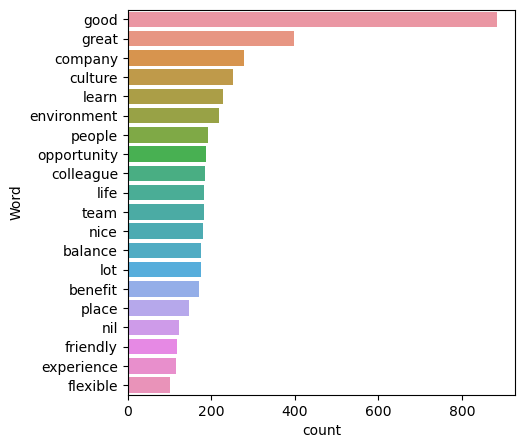

In [69]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(data_df['all_text'], 20)

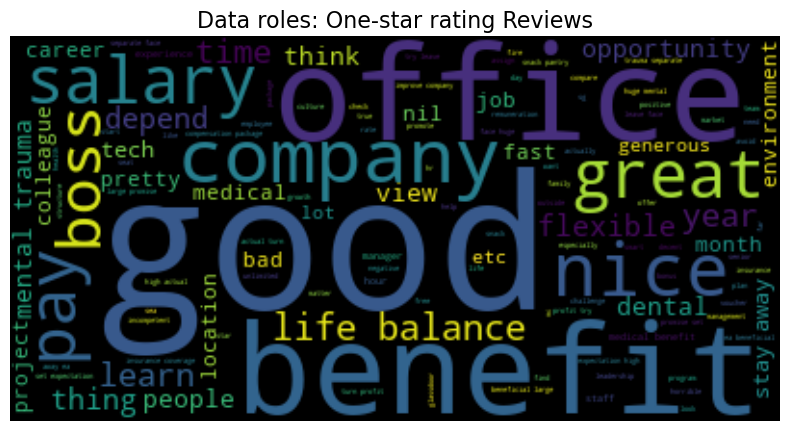

In [70]:
# Filter the rows where the rating is 1 and select the 'all_text' column
onestar_alltext = data_df.loc[data_df['rating'] == 1, 'all_text']

# Concatenate all the pros into a single string
onestar_alltext = ' '.join(onestar_alltext.astype(str))

# Create the word cloud object
wordcloud_onestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_alltext)

# Set the title for the word cloud
title = "Data roles: One-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

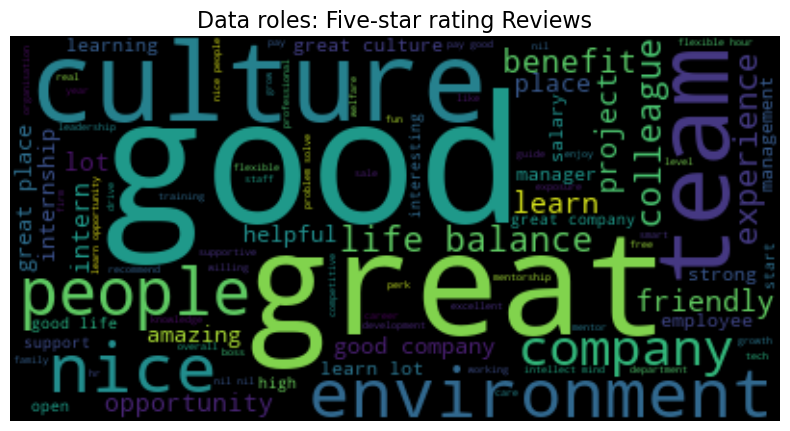

In [71]:
# Filter the rows where the rating is 1 and select the 'all_text' column
fivestar_alltext = data_df.loc[data_df['rating'] == 5, 'all_text']

# Concatenate all the pros into a single string
fivestar_alltext = ' '.join(fivestar_alltext.astype(str))

# Create the word cloud object
wordcloud_fivestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_alltext)

# Set the title for the word cloud
title = "Data roles: Five-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

### For developer roles

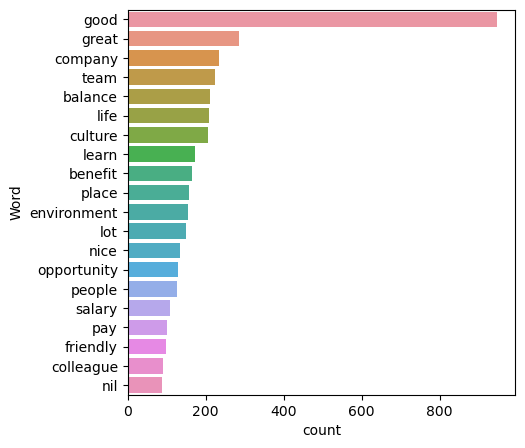

In [72]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(developer_df['all_text'], 20)

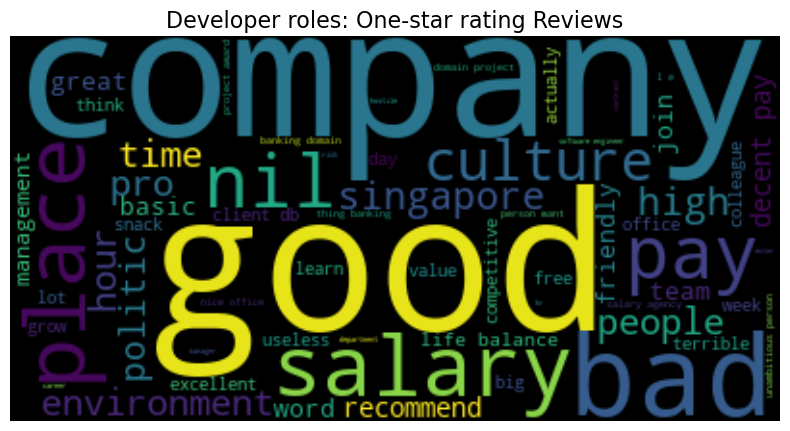

In [73]:
# Filter the rows where the rating is 1 and select the 'all_text' column
onestar_alltext = developer_df.loc[developer_df['rating'] == 1, 'all_text']

# Concatenate all the pros into a single string
onestar_alltext = ' '.join(onestar_alltext.astype(str))

# Create the word cloud object
wordcloud_onestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_alltext)

# Set the title for the word cloud
title = "Developer roles: One-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

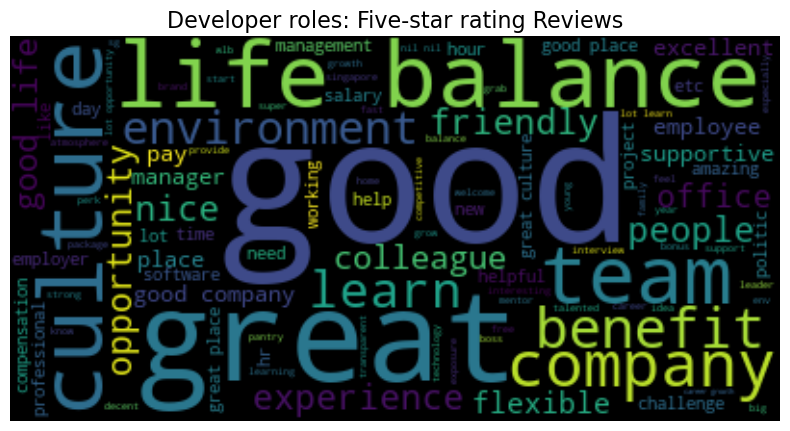

In [74]:
# Filter the rows where the rating is 1 and select the 'all_text' column
fivestar_alltext = developer_df.loc[developer_df['rating'] == 5, 'all_text']

# Concatenate all the pros into a single string
fivestar_alltext = ' '.join(fivestar_alltext.astype(str))

# Create the word cloud object
wordcloud_fivestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_alltext)

# Set the title for the word cloud
title = "Developer roles: Five-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

### For leadership roles

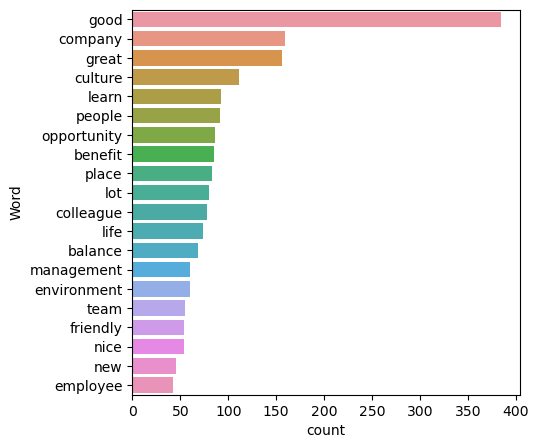

In [75]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(leadership_df['all_text'], 20)

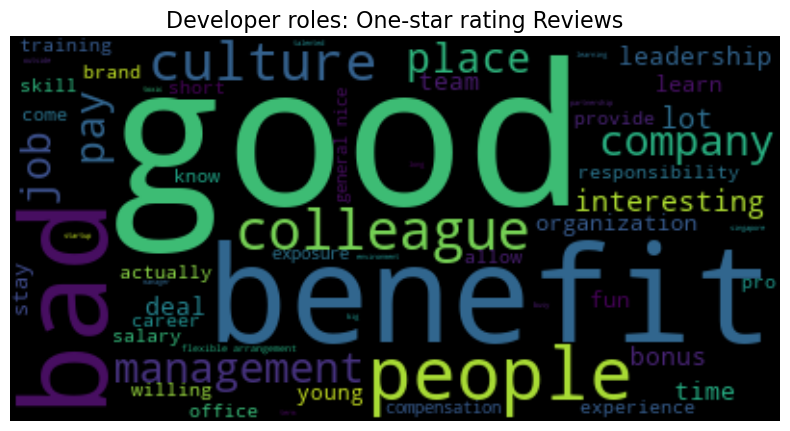

In [76]:
# Filter the rows where the rating is 1 and select the 'all_text' column
onestar_alltext = leadership_df.loc[leadership_df['rating'] == 1, 'all_text']

# Concatenate all the pros into a single string
onestar_alltext = ' '.join(onestar_alltext.astype(str))

# Create the word cloud object
wordcloud_onestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_alltext)

# Set the title for the word cloud
title = "Developer roles: One-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

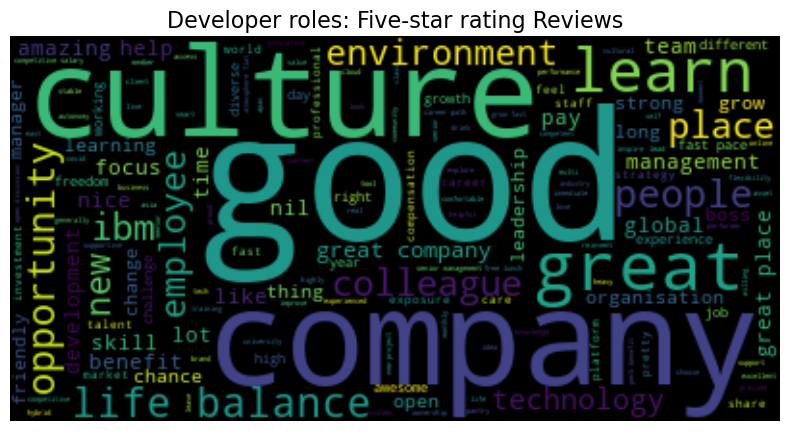

In [77]:
# Filter the rows where the rating is 1 and select the 'all_text' column
fivestar_alltext = leadership_df.loc[leadership_df['rating'] == 5, 'all_text']

# Concatenate all the pros into a single string
fivestar_alltext = ' '.join(fivestar_alltext.astype(str))

# Create the word cloud object
wordcloud_fivestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_alltext)

# Set the title for the word cloud
title = "Developer roles: Five-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

### For engineering roles

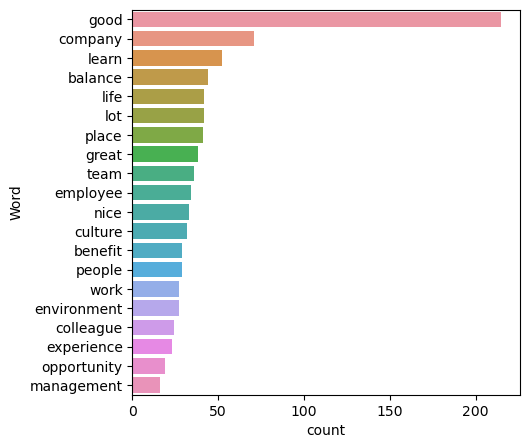

In [78]:
def freq_words(x, terms = 30): 
  all_words = ' '.join([text for text in x]) 
  all_words = all_words.split() 
  fdist = nltk.FreqDist(all_words) 
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  # selecting top 20 most frequent words 
  d = words_df.nlargest(columns="count", n = terms) 
  
  # visualize words and frequencies
  plt.figure(figsize=(5,5)) 
  ax = sns.barplot(data=d, x= "count", y = "word") 
  ax.set(ylabel = 'Word') 
  plt.show()
  
# print 20 most frequent words 
freq_words(engineer_df['all_text'], 20)

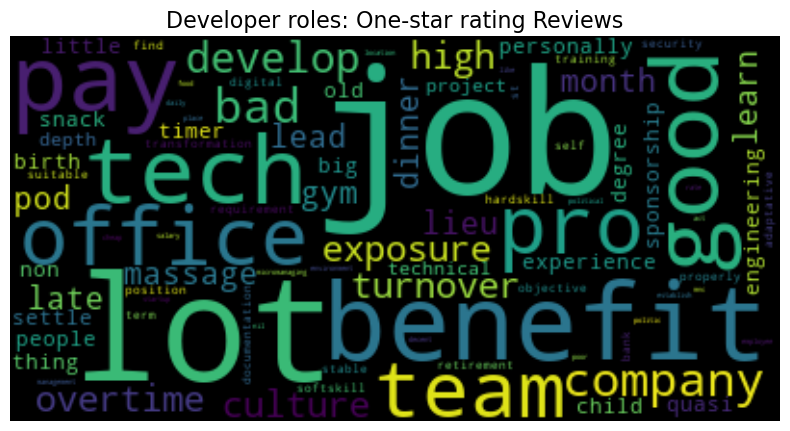

In [79]:
# Filter the rows where the rating is 1 and select the 'all_text' column
onestar_alltext = engineer_df.loc[engineer_df['rating'] == 1, 'all_text']

# Concatenate all the pros into a single string
onestar_alltext = ' '.join(onestar_alltext.astype(str))

# Create the word cloud object
wordcloud_onestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(onestar_alltext)

# Set the title for the word cloud
title = "Developer roles: One-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_onestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

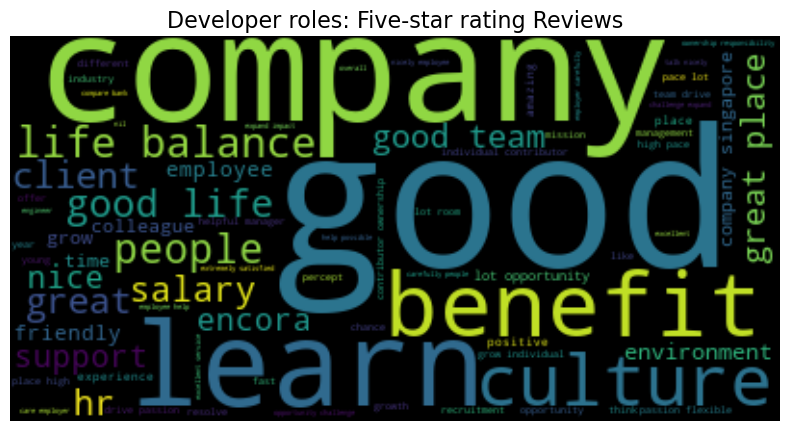

In [80]:
# Filter the rows where the rating is 1 and select the 'all_text' column
fivestar_alltext = engineer_df.loc[engineer_df['rating'] == 5, 'all_text']

# Concatenate all the pros into a single string
fivestar_alltext = ' '.join(fivestar_alltext.astype(str))

# Create the word cloud object
wordcloud_fivestar_alltext = WordCloud(stopwords=spacy_stopwords, collocations=True).generate(fivestar_alltext)

# Set the title for the word cloud
title = "Developer roles: Five-star rating Reviews"

# Plot the word cloud object
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fivestar_alltext, interpolation='bilinear')
plt.title(title, fontsize=16)
plt.axis('off')
plt.show()

## Topic modelling using LDA


In [81]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import pyLDAvis
import matplotlib.pyplot as plt

### For all roles

In [82]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations
data_words = list(sent_to_words(cleaned_df['all_text']))
print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1])

[['support', 'hr', 'helpful', 'understanding', 'hr', 'helpful', 'understanding']]
['support', 'hr', 'helpful', 'understanding', 'hr', 'helpful', 'understanding']
[['support', 'hr', 'helpful', 'understanding', 'hr', 'helpful', 'understanding']]


In [83]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 2)]]


In [84]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

[(0,
  '0.123*"learn" + 0.114*"opportunity" + 0.059*"nil" + 0.039*"grow" + '
  '0.039*"new" + 0.037*"technology" + 0.035*"growth" + 0.031*"exposure" + '
  '0.027*"industry" + 0.024*"company"'),
 (1,
  '0.438*"good" + 0.075*"benefit" + 0.045*"pay" + 0.044*"salary" + '
  '0.029*"place" + 0.028*"high" + 0.018*"stack" + 0.015*"tech" + 0.014*"bonus" '
  '+ 0.013*"different"'),
 (2,
  '0.085*"time" + 0.036*"provide" + 0.034*"big" + 0.030*"strong" + '
  '0.024*"willing" + 0.022*"day" + 0.018*"depend" + 0.017*"senior" + '
  '0.017*"help" + 0.016*"program"'),
 (3,
  '0.111*"employee" + 0.064*"project" + 0.057*"job" + 0.034*"staff" + '
  '0.030*"training" + 0.024*"dynamic" + 0.023*"home" + 0.021*"level" + '
  '0.020*"young" + 0.018*"arrangement"'),
 (4,
  '0.176*"life" + 0.171*"balance" + 0.038*"bad" + 0.037*"client" + '
  '0.031*"company" + 0.019*"year" + 0.018*"average" + 0.016*"pro" + '
  '0.015*"singapore" + 0.014*"pretty"'),
 (5,
  '0.160*"team" + 0.079*"flexible" + 0.075*"management" + 0.0

In [85]:
import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.315165  0.162746       1        1  23.189612
1      0.185568 -0.348232       2        1  16.630381
0      0.154018  0.040309       3        1  11.491925
5     -0.111729  0.080167       4        1   9.101121
4      0.028985  0.197238       5        1   8.716518
2     -0.099487 -0.034413       6        1   7.468118
3     -0.130463 -0.020339       7        1   7.260030
6     -0.143880  0.034411       8        1   6.107859
9     -0.083399 -0.114968       9        1   5.993568
7     -0.114778  0.003080      10        1   4.040868, topic_info=            Term         Freq        Total Category  logprob  loglift
6           good  2458.000000  2458.000000  Default  30.0000  30.0000
17         great   921.000000   921.000000  Default  29.0000  29.0000
19          life   518.000000   518.000000  Default  28.0000  28.0000
11       balance   503.000000   503.000000  Default  27.0000  27.0000
87           lot   380.000000   380.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1765         org     9.270775    10.110504  Topic10  -4.9896   3.1220
2272        mile     9.132489     9.973124  Topic10  -5.0046   3.1207
1445      design     7.981457     8.821020  Topic10  -5.1393   3.1087
1856   education     7.800400     8.640263  Topic10  -5.1623   3.1065
692   contribute     7.502392     8.342414  Topic10  -5.2012   3.1026

[365 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
563       8  0.971048       able
142       1  0.984758   activity
102       9  0.979468   actually
1679      9  0.985281     agency
312       6  0.967483      allow
...     ...       ...        ...
59        4  0.025133       work
100       1  0.996816    working
216       2  0.964308  workplace
9         5  0.993824       year
278       7  0.987275      young

[355 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 1, 6, 5, 3, 4, 7, 10, 8])

In [86]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.059*"learn" + 0.056*"lot" + 0.055*"opportunity" + 0.050*"great" + '
  '0.029*"place" + 0.028*"company" + 0.028*"nil" + 0.021*"technology" + '
  '0.019*"grow" + 0.019*"people"'),
 (1,
  '0.223*"good" + 0.051*"life" + 0.049*"balance" + 0.048*"culture" + '
  '0.044*"company" + 0.040*"environment" + 0.038*"benefit" + 0.037*"great" + '
  '0.024*"pay" + 0.024*"people"'),
 (2,
  '0.057*"nice" + 0.042*"flexible" + 0.031*"office" + 0.028*"project" + '
  '0.023*"tech" + 0.017*"stack" + 0.017*"high" + 0.015*"hr" + 0.014*"care" + '
  '0.014*"big"'),
 (3,
  '0.079*"team" + 0.041*"friendly" + 0.033*"time" + 0.032*"employee" + '
  '0.026*"hour" + 0.023*"manager" + 0.021*"helpful" + 0.020*"great" + '
  '0.017*"colleague" + 0.015*"excellent"'),
 (4,
  '0.031*"company" + 0.023*"bad" + 0.022*"client" + 0.018*"management" + '
  '0.016*"employee" + 0.015*"family" + 0.014*"singapore" + 0.012*"year" + '
  '0.011*"high" + 0.011*"professional"')]

Perplexity:  -6.32508622967883

Coherence Score:  0.3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.227709 -0.013455       1        1  30.603394
0      0.182072 -0.195131       2        1  21.950572
3     -0.012343  0.258035       3        1  17.156547
2     -0.297413 -0.186588       4        1  17.145255
4     -0.100024  0.137139       5        1  13.144232, topic_info=           Term         Freq        Total Category  logprob  loglift
6          good  2295.000000  2295.000000  Default  30.0000  30.0000
79         team   458.000000   458.000000  Default  29.0000  29.0000
83        learn   435.000000   435.000000  Default  28.0000  28.0000
87          lot   413.000000   413.000000  Default  27.0000  27.0000
19         life   526.000000   526.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
32     employee    69.633789   252.318406   Topic5  -4.1527   0.7417
75         high    50.148998   147.540660   Topic5  -4.4810   0.9501
278       young    29.208461    47.327045   Topic5  -5.0215   1.5466
272        perk    27.120243    48.721607   Topic5  -5.0957   1.4433
15   experience    27.608659   244.699648   Topic5  -5.0778  -0.1527

[227 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
563       2  0.984957         able
142       3  0.975341     activity
1679      5  0.982981       agency
170       2  0.981981      amazing
601       5  0.977925  arrangement
...     ...       ...          ...
100       3  0.087976      working
216       1  0.963211    workplace
9         5  0.986165         year
278       4  0.380332        young
278       5  0.612757        young

[218 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3, 5])

### For data roles

In [87]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

# Convert the filtered titles to a list of words
data_words = list(sent_to_words(data_df['all_text']))
print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1])

[['outstanding', 'experience', 'great', 'colleague', 'positive', 'attitude', 'opportunity', 'professional', 'development', 'preferences', 'give', 'choice', 'welcome', 'new', 'idea', 'life', 'balance', 'great', 'colleague', 'positive', 'attitude', 'opportunity', 'professional', 'development', 'preference', 'choice', 'welcome', 'new', 'idea', 'life', 'balance']]
['outstanding', 'experience', 'great', 'colleague', 'positive', 'attitude', 'opportunity', 'professional', 'development', 'preferences', 'give', 'choice', 'welcome', 'new', 'idea', 'life', 'balance', 'great', 'colleague', 'positive', 'attitude', 'opportunity', 'professional', 'development', 'preference', 'choice', 'welcome', 'new', 'idea', 'life', 'balance']
[['outstanding', 'experience', 'great', 'colleague', 'positive', 'attitude', 'opportunity', 'professional', 'development', 'preferences', 'give', 'choice', 'welcome', 'new', 'idea', 'life', 'balance', 'great', 'colleague', 'positive', 'attitude', 'opportunity', 'professional'

In [88]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 2), (1, 2), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 1), (13, 2), (14, 1), (15, 1), (16, 2), (17, 2)]]


In [89]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.034*"employee" + 0.020*"people" + 0.020*"company" + 0.015*"fun" + '
  '0.015*"time" + 0.012*"willing" + 0.012*"high" + 0.012*"help" + '
  '0.012*"smart" + 0.010*"great"'),
 (1,
  '0.063*"opportunity" + 0.042*"learn" + 0.037*"great" + 0.036*"lot" + '
  '0.032*"company" + 0.028*"office" + 0.020*"growth" + 0.020*"exposure" + '
  '0.019*"client" + 0.016*"career"'),
 (2,
  '0.059*"life" + 0.053*"balance" + 0.033*"team" + 0.029*"good" + '
  '0.028*"flexible" + 0.028*"great" + 0.021*"culture" + 0.018*"working" + '
  '0.016*"management" + 0.015*"benefit"'),
 (3,
  '0.160*"good" + 0.047*"environment" + 0.039*"company" + 0.037*"nice" + '
  '0.036*"culture" + 0.036*"great" + 0.028*"colleague" + 0.028*"people" + '
  '0.024*"nil" + 0.021*"place"'),
 (4,
  '0.023*"salary" + 0.020*"strong" + 0.020*"time" + 0.019*"different" + '
  '0.019*"high" + 0.018*"bad" + 0.017*"pay" + 0.016*"benefit" + '
  '0.015*"competitive" + 0.013*"stable"')]

Perplexity:  -6.210024283745565

Coherence Score:  0.27

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.198038  0.080666       1        1  33.693344
2      0.108950  0.192102       2        1  21.782121
1      0.111646 -0.275605       3        1  18.927235
4     -0.279039  0.041151       4        1  13.302545
0     -0.139595 -0.038314       5        1  12.294755, topic_info=            Term        Freq       Total Category  logprob  loglift
23          good  830.000000  830.000000  Default  30.0000  30.0000
11   opportunity  161.000000  161.000000  Default  29.0000  29.0000
9           life  172.000000  172.000000  Default  28.0000  28.0000
1        balance  156.000000  156.000000  Default  27.0000  27.0000
48   environment  216.000000  216.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
7          great   16.479211  355.031375   Topic5  -4.6070  -0.9741
25    management   12.036855   77.132503   Topic5  -4.9211   0.2384
3      colleague   11.623004  147.962500   Topic5  -4.9561  -0.4480
427         boss    9.722314   41.202930   Topic5  -5.1347   0.6519
45          work    9.909706  100.300102   Topic5  -5.1156  -0.2187

[264 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
280       5  0.944703        able
18        2  0.977888  accessible
1246      4  0.988647      agency
322       1  0.924214       allow
237       3  0.916895     amazing
...     ...       ...         ...
45        4  0.039880        work
45        5  0.099701        work
51        2  0.982666     working
333       1  0.924373       world
132       5  0.977109       young

[286 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 5, 1])

### For developer roles

In [90]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

# Filter the DataFrame based on the "title_simp" column
developer_df = cleaned_df[cleaned_df['title_simp'] == 'Developer roles']

# Convert the filtered titles to a list of words
data_words = list(sent_to_words(developer_df['all_text']))
print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1])

[['year', 'contractual', 'asia', 'good', 'stepping', 'stone', 'overseas', 'good', 'stepping', 'stone', 'overseas']]
['year', 'contractual', 'asia', 'good', 'stepping', 'stone', 'overseas', 'good', 'stepping', 'stone', 'overseas']
[['year', 'contractual', 'asia', 'good', 'stepping', 'stone', 'overseas', 'good', 'stepping', 'stone', 'overseas']]


In [91]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 2), (6, 1)]]


In [92]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.088*"good" + 0.061*"nice" + 0.043*"salary" + 0.028*"colleague" + '
  '0.027*"benefit" + 0.024*"office" + 0.023*"industry" + 0.020*"experience" + '
  '0.020*"helpful" + 0.014*"average"'),
 (1,
  '0.148*"good" + 0.062*"great" + 0.047*"balance" + 0.046*"culture" + '
  '0.045*"life" + 0.037*"company" + 0.024*"place" + 0.022*"environment" + '
  '0.021*"team" + 0.021*"benefit"'),
 (2,
  '0.049*"employee" + 0.036*"team" + 0.029*"company" + 0.028*"manager" + '
  '0.028*"tech" + 0.022*"stack" + 0.020*"lot" + 0.019*"pay" + 0.016*"software" '
  '+ 0.015*"care"'),
 (3,
  '0.046*"lot" + 0.036*"learn" + 0.027*"new" + 0.025*"time" + '
  '0.020*"technology" + 0.018*"home" + 0.018*"place" + 0.018*"provide" + '
  '0.015*"program" + 0.015*"need"'),
 (4,
  '0.024*"pay" + 0.020*"day" + 0.015*"high" + 0.015*"wfh" + 0.012*"know" + '
  '0.012*"leadership" + 0.012*"office" + 0.012*"internal" + 0.011*"leave" + '
  '0.011*"hr"')]

Perplexity:  -6.138695834414181

Coherence Score:  0.3408006802855291


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.263492  0.002745       1        1  41.833494
2     -0.080229  0.005846       2        1  15.650448
0      0.139301  0.046190       3        1  15.209125
3     -0.127495 -0.257121       4        1  13.739217
4     -0.195070  0.202340       5        1  13.567716, topic_info=           Term        Freq       Total Category  logprob  loglift
2          good  907.000000  907.000000  Default  30.0000  30.0000
47         nice  110.000000  110.000000  Default  29.0000  29.0000
43        great  322.000000  322.000000  Default  28.0000  28.0000
185     balance  230.000000  230.000000  Default  27.0000  27.0000
204        life  222.000000  222.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
117    friendly   14.668227   82.149352   Topic5  -4.6927   0.2746
27   experience   12.767659   66.919851   Topic5  -4.8315   0.3409
55         team   14.577243  186.589680   Topic5  -4.6989  -0.5520
43        great   13.620331  322.336351   Topic5  -4.7668  -1.1666
92       people   11.090568  114.611862   Topic5  -4.9723  -0.3380

[255 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
483       4  0.904228          able
133       5  0.872866         allow
84        1  0.964094       amazing
537       4  0.880095   application
919       5  0.957078  approachable
...     ...       ...           ...
23        1  0.988530          work
238       1  0.986496       working
443       2  0.916844      workload
6         1  0.976369          year
626       3  0.933682         young

[270 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4, 5])

### For Leadership roles

In [93]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

# Filter the DataFrame based on the "title_simp" column
leadership_df = cleaned_df[cleaned_df['title_simp'] == 'Leadership roles']

# Convert the filtered titles to a list of words
data_words = list(sent_to_words(leadership_df['all_text']))
print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1])

[['great', 'company', 'learn', 'grow', 'good', 'place', 'start', 'learn', 'life', 'balance', 'good', 'place', 'start', 'learn', 'life', 'balance']]
['great', 'company', 'learn', 'grow', 'good', 'place', 'start', 'learn', 'life', 'balance', 'good', 'place', 'start', 'learn', 'life', 'balance']
[['great', 'company', 'learn', 'grow', 'good', 'place', 'start', 'learn', 'life', 'balance', 'good', 'place', 'start', 'learn', 'life', 'balance']]


In [94]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 3), (6, 2), (7, 2), (8, 2)]]


In [95]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.065*"good" + 0.037*"colleague" + 0.029*"people" + 0.028*"salary" + '
  '0.025*"friendly" + 0.023*"company" + 0.020*"management" + 0.020*"nice" + '
  '0.019*"culture" + 0.017*"competitive"'),
 (1,
  '0.041*"learn" + 0.040*"great" + 0.035*"grow" + 0.031*"opportunity" + '
  '0.025*"fast" + 0.024*"lot" + 0.024*"place" + 0.024*"company" + 0.015*"new" '
  '+ 0.014*"global"'),
 (2,
  '0.130*"good" + 0.045*"benefit" + 0.028*"people" + 0.026*"environment" + '
  '0.024*"culture" + 0.023*"company" + 0.023*"pay" + 0.014*"startup" + '
  '0.014*"strong" + 0.013*"place"'),
 (3,
  '0.058*"culture" + 0.046*"great" + 0.041*"good" + 0.035*"company" + '
  '0.019*"family" + 0.019*"lot" + 0.019*"opportunity" + 0.017*"team" + '
  '0.016*"bad" + 0.015*"learning"'),
 (4,
  '0.035*"life" + 0.035*"balance" + 0.021*"opportunity" + 0.021*"good" + '
  '0.020*"job" + 0.020*"company" + 0.018*"colleague" + 0.015*"time" + '
  '0.013*"potential" + 0.013*"give"')]

Perplexity:  -6.239973238335071

Coherence Sco

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.183082 -0.069575       1        1  22.458114
1     -0.244522 -0.057622       2        1  21.235196
3     -0.052548 -0.085094       3        1  20.629930
0      0.114014 -0.051017       4        1  18.373761
4     -0.000026  0.263309       5        1  17.302999, topic_info=             Term        Freq       Total Category  logprob  loglift
2            good  341.000000  341.000000  Default  30.0000  30.0000
23        benefit   76.000000   76.000000  Default  29.0000  29.0000
18        culture  133.000000  133.000000  Default  28.0000  28.0000
4            grow   48.000000   48.000000  Default  27.0000  27.0000
5           learn   66.000000   66.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
16   compensation   10.951534   32.161748   Topic5  -4.6180   0.6770
160        people   12.465257   96.213678   Topic5  -4.4885  -0.2893
103          open    9.311289   29.873392   Topic5  -4.7803   0.5885
61           team    9.739863   41.847085   Topic5  -4.7353   0.2965
7           place    9.623990   75.521765   Topic5  -4.7472  -0.3059

[272 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
788       2  0.917563  aggressively
381       2  0.889112          alot
385       1  0.877128       alright
146       5  0.974846  approachable
312       2  0.865044   arrangement
...     ...       ...           ...
143       3  0.105517          work
143       4  0.281379          work
1012      2  0.861048     workplace
111       1  0.799705         young
111       5  0.199926         young

[308 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])

### For Engineer roles

In [96]:
def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))            #deacc=True removes punctuations

# Filter the DataFrame based on the "title_simp" column
engineer_df = cleaned_df[cleaned_df['title_simp'] == 'Engineer roles']

# Convert the filtered titles to a list of words
data_words = list(sent_to_words(engineer_df['all_text']))
print(data_words[:1])

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

print(data_words_bigrams[:1])

[['support', 'hr', 'helpful', 'understanding', 'hr', 'helpful', 'understanding']]
['support', 'hr', 'helpful', 'understanding', 'hr', 'helpful', 'understanding']
[['support', 'hr', 'helpful', 'understanding', 'hr', 'helpful', 'understanding']]


In [97]:
# Create Dictionary 
id2word = corpora.Dictionary(data_words_bigrams)  
# Create Corpus 
texts = data_words_bigrams 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts]  
# View 
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 2)]]


In [98]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the keyword of topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

[(0,
  '0.076*"good" + 0.072*"place" + 0.052*"learn" + 0.039*"great" + 0.033*"life" '
  '+ 0.030*"balance" + 0.026*"nil" + 0.025*"lot" + 0.021*"pace" + '
  '0.021*"start"'),
 (1,
  '0.050*"experience" + 0.042*"lot" + 0.037*"environment" + 0.025*"stable" + '
  '0.023*"st" + 0.021*"learn" + 0.020*"bad" + 0.019*"engineering" + '
  '0.018*"colleague" + 0.017*"like"'),
 (2,
  '0.190*"good" + 0.053*"balance" + 0.045*"life" + 0.041*"team" + '
  '0.039*"management" + 0.025*"food" + 0.021*"company" + 0.020*"colleague" + '
  '0.017*"client" + 0.015*"friendly"'),
 (3,
  '0.078*"company" + 0.048*"work" + 0.026*"good" + 0.022*"learn" + '
  '0.020*"opportunity" + 0.019*"hour" + 0.018*"talk" + 0.018*"flexible" + '
  '0.018*"grow" + 0.016*"different"'),
 (4,
  '0.104*"good" + 0.060*"culture" + 0.037*"pay" + 0.033*"employee" + '
  '0.033*"job" + 0.026*"hr" + 0.018*"percept" + 0.016*"learn" + '
  '0.016*"amazing" + 0.016*"bank"')]

Perplexity:  -5.421189660537537

Coherence Score:  0.4292487214080408


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.147579  0.004689       1        1  24.933484
0      0.063377 -0.118439       2        1  21.805465
1     -0.116958 -0.144388       3        1  19.385082
4      0.105252  0.135831       4        1  16.970477
3     -0.199251  0.122306       5        1  16.905491, topic_info=        Term        Freq       Total Category  logprob  loglift
12      good  192.000000  192.000000  Default  30.0000  30.0000
27     place   39.000000   39.000000  Default  29.0000  29.0000
44   culture   24.000000   24.000000  Default  28.0000  28.0000
30   balance   43.000000   43.000000  Default  27.0000  27.0000
43   company   49.000000   49.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
37     learn    8.317710   48.443806   Topic5  -3.7976   0.0155
12      good    9.721109  192.032067   Topic5  -3.6417  -1.2058
64    people    4.513382   20.472276   Topic5  -4.4089   0.2655
5     client    3.880546   13.752866   Topic5  -4.5600   0.5123
8   employee    4.219118   23.946706   Topic5  -4.4763   0.0413

[249 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
377       4  0.741043        able
384       5  0.798118  adaptative
380       5  0.797820       adopt
410       4  0.741074       agoda
368       3  0.920694        alot
...     ...       ...         ...
182       2  0.457797     working
182       3  0.343348     working
182       4  0.114449     working
118       1  0.922939    worklife
29        1  0.944487        year

[283 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

## Topic modelling using BERTopic


In [125]:
from bertopic import BERTopic
topic_model = BERTopic(min_topic_size=25, n_gram_range=(2,3), verbose=True)
topics, _ = topic_model.fit_transform(cleaned_df['all_text'])

freq = topic_model.get_topic_info()
freq.head(10)

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

2023-06-23 19:25:26,564 - BERTopic - Transformed documents to Embeddings
2023-06-23 19:25:33,584 - BERTopic - Reduced dimensionality
2023-06-23 19:25:33,662 - BERTopic - Clustered reduced embeddings


Topic  Count                                               Name  \
0     -1    732  -1_life balance_good life_balance good_great p...   
1      0    353  0_lot opportunity_learn lot_place learn_opport...   
2      1    185  1_colleague good_friendly colleague_good colle...   
3      2    148  2_good benefit_good salary_salary good_benefit...   
4      3    120  3_good culture_culture good_great culture_comp...   
5      4     84  4_life balance_good life balance_good life_bal...   
6      5     72  5_good environment_environment good_great envi...   
7      6     57  6_learn lot_internship experience_intern good_...   
8      7     57  7_flexible arrangement_flexible work_flexible ...   
9      8     56  8_good company_company good_company good compa...   

                                      Representation  \
0  [life balance, good life, balance good, great ...   
1  [lot opportunity, learn lot, place learn, oppo...   
2  [colleague good, friendly colleague, good coll...   
3  [good benefit, good salary, salary good, benef...   
4  [good culture, culture good, great culture, co...   
5  [life balance, good life balance, good life, b...   
6  [good environment, environment good, great env...   
7  [learn lot, internship experience, intern good...   
8  [flexible arrangement, flexible work, flexible...   
9  [good company, company good, company good comp...   

                                 Representative_Docs  
0  [ok life balance good environment life balance...  
1  [brilliant team superb life balance brilliant ...  
2  [product engineer good work life balance good ...  
3  [far good good salary good benefit good work e...  
4  [good company good company great culture good ...  
5  [nil life balance good life balance good, good...  
6  [nil good environment nice people good environ...  
7  [enjoyable internship intern buddy provide lot...  
8  [gojek overview autonomous flexible working ho...  
9  [good good company good company, good company ...

In [126]:
topic_model.get_topic(-1)

[('life balance', 0.019412328391042052),
 ('good life', 0.009164627351066068),
 ('balance good', 0.009007565418676125),
 ('great place', 0.00892542311971257),
 ('good life balance', 0.008685568615673319),
 ('good place', 0.00861353789224967),
 ('life balance good', 0.008293518564987308),
 ('good company', 0.007023402927024338),
 ('nil nil', 0.006347390434594895),
 ('team good', 0.005877789116692933)]

In [127]:
topic_model.visualize_topics()

In [128]:
topic_model.visualize_heatmap()

### For data roles

In [129]:
topic_model = BERTopic(min_topic_size=25, n_gram_range=(2,3), verbose=True)
topics, _ = topic_model.fit_transform(data_df['all_text'])

freq = topic_model.get_topic_info()
freq.head(10)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

2023-06-23 19:26:01,218 - BERTopic - Transformed documents to Embeddings
2023-06-23 19:26:05,254 - BERTopic - Reduced dimensionality
2023-06-23 19:26:05,283 - BERTopic - Clustered reduced embeddings


Topic  Count                                               Name  \
0     -1    305  -1_life balance_nil nil_good company_company g...   
1      0     83  0_colleague good_friendly colleague_good colle...   
2      1     82   1_benefit good_good pay_good benefit_salary good   
3      2     77  2_lot opportunity_learn lot_good place_place l...   
4      3     67  3_good culture_good environment_great culture_...   
5      4     60  4_life balance_mental trauma_great team_accoun...   
6      5     54  5_life balance_good life balance_good life_fle...   
7      6     46  6_learn lot_lot internship_learn lot internshi...   

                                      Representation  \
0  [life balance, nil nil, good company, company ...   
1  [colleague good, friendly colleague, good coll...   
2  [benefit good, good pay, good benefit, salary ...   
3  [lot opportunity, learn lot, good place, place...   
4  [good culture, good environment, great culture...   
5  [life balance, mental trauma, great team, acco...   
6  [life balance, good life balance, good life, f...   
7  [learn lot, lot internship, learn lot internsh...   

                                 Representative_Docs  
0  [great teammate messy leadership minimal offic...  
1  [internship friendly colleague good life balan...  
2  [great benefit big company look diversity actu...  
3  [opportunity grow good place learn opportunity...  
4  [good culture good culture team join friendly ...  
5  [pro con truthful manipulate information hones...  
6  [workculture give good life balance good life ...  
7  [great internship great place learn lot far ba...

In [130]:
topic_model.get_topic(-1)

[('life balance', 0.01901610707807906),
 ('nil nil', 0.014832604530052664),
 ('good company', 0.01152324086316223),
 ('company great', 0.00988287425843764),
 ('great company', 0.009727455564191287),
 ('great place', 0.009259495477107646),
 ('nice office', 0.008275577460374075),
 ('good life balance', 0.008240335850029257),
 ('good life', 0.008201068466200473),
 ('company culture', 0.007857599079535926)]

In [131]:
topic_model.visualize_topics()


In [132]:
topic_model.visualize_heatmap()

### For developer roles

In [157]:
topic_model = BERTopic(min_topic_size=15, n_gram_range=(2,3), verbose=True)
topics, _ = topic_model.fit_transform(developer_df['all_text'])

freq = topic_model.get_topic_info()
freq.head(10)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

2023-06-23 19:29:15,601 - BERTopic - Transformed documents to Embeddings
2023-06-23 19:29:19,537 - BERTopic - Reduced dimensionality
2023-06-23 19:29:19,559 - BERTopic - Clustered reduced embeddings


Topic  Count                                               Name  \
0     -1    293  -1_life balance_good environment_good benefit_...   
1      0    109  0_tech stack_new technology_learn lot_life bal...   
2      1     57  1_good culture_culture good_great culture_life...   
3      2     44  2_life balance_good life balance_good life_lif...   
4      3     35  3_good place_good company_good place good_plac...   
5      4     32    4_good salary_salary good_salary wlb_high basic   
6      5     32  5_nil nil_nil nil nil_company nil nil_company nil   
7      6     26  6_colleague good_friendly colleague_helpful co...   
8      7     22  7_career growth_lot learn opportunity_learn op...   

                                      Representation  \
0  [life balance, good environment, good benefit,...   
1  [tech stack, new technology, learn lot, life b...   
2  [good culture, culture good, great culture, li...   
3  [life balance, good life balance, good life, l...   
4  [good place, good company, good place good, pl...   
5  [good salary, salary good, salary wlb, high ba...   
6  [nil nil, nil nil nil, company nil nil, compan...   
7  [colleague good, friendly colleague, helpful c...   
8  [career growth, lot learn opportunity, learn o...   

                                 Representative_Docs  
0  [nil life balance good life balance good, grea...  
1  [good career opportunity brand low compensatio...  
2  [life balance good team good life balance inte...  
3  [excellent workplace good life balance good li...  
4  [good place good place good place, good good c...  
5  [good good salary good comp good salary good c...  
6  [good company nil nil, nil nil nil, good compa...  
7  [good company good learning opportunity friend...  
8  [great opportunity growth excellent culture br...

In [158]:
topic_model.get_topic(-1)

[('life balance', 0.019687336056646354),
 ('good environment', 0.010864572300920226),
 ('good benefit', 0.010575004770092048),
 ('great place', 0.009611971123291053),
 ('life balance good', 0.008687196019814235),
 ('good life balance', 0.00857690432656989),
 ('balance good', 0.008541350006612807),
 ('good life', 0.008541350006612807),
 ('good team', 0.00815515635741793),
 ('environment life', 0.00794748978188042)]

In [159]:
topic_model.visualize_topics()


In [160]:
topic_model.visualize_heatmap()

### For leadership roles

In [195]:
topic_model = BERTopic(min_topic_size=13, n_gram_range=(2,3), verbose=True)
topics, _ = topic_model.fit_transform(leadership_df['all_text'])

freq = topic_model.get_topic_info()
freq.head(10)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2023-06-23 19:33:06,606 - BERTopic - Transformed documents to Embeddings
2023-06-23 19:33:10,488 - BERTopic - Reduced dimensionality
2023-06-23 19:33:10,506 - BERTopic - Clustered reduced embeddings


Topic  Count                                               Name  \
0     -1    135  -1_great place_life balance_great culture_good...   
1      0     69  0_great company_life balance_company culture_o...   
2      1     51  1_benefit good_life balance_good benefit_envir...   
3      2     25  2_friendly colleague_good colleague_colleague ...   
4      3     23    3_grow fast_lot learn_lot opportunity_fast grow   
5      4     15  4_good company_company good_good company good_...   
6      5     14  5_good company culture_culture good_people cul...   

                                      Representation  \
0  [great place, life balance, great culture, goo...   
1  [great company, life balance, company culture,...   
2  [benefit good, life balance, good benefit, env...   
3  [friendly colleague, good colleague, colleague...   
4  [grow fast, lot learn, lot opportunity, fast g...   
5  [good company, company good, good company good...   
6  [good company culture, culture good, people cu...   

                                 Representative_Docs  
0  [pretty good competent salary option negotiate...  
1  [good cloud consultant market awesome company ...  
2  [good place benefit good salary good benefit g...  
3  [singtel friendly colleague support internal t...  
4  [high growth opportunity fast paced lot learn ...  
5  [good good company good propsect good company ...  
6  [great company great benefit amazing culture d...

In [196]:
topic_model.get_topic(-1)

[('great place', 0.01817187171905447),
 ('life balance', 0.01746572127964256),
 ('great culture', 0.015437610266883183),
 ('good place', 0.013383505411185813),
 ('place learn', 0.009924178028710618),
 ('good company', 0.009528312750169046),
 ('competitive salary', 0.009351819371866335),
 ('great place great', 0.007974934525685038),
 ('place great', 0.007974934525685038),
 ('good benefit', 0.007794060378977559)]

In [197]:
topic_model.visualize_topics()


In [198]:
topic_model.visualize_heatmap()

### For engineering roles

In [229]:
topic_model = BERTopic(min_topic_size=6, n_gram_range=(2,3), verbose=True)
topics, _ = topic_model.fit_transform(engineer_df['all_text'])

freq = topic_model.get_topic_info()
freq.head(10)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

2023-06-23 19:35:46,367 - BERTopic - Transformed documents to Embeddings
2023-06-23 19:35:50,166 - BERTopic - Reduced dimensionality
2023-06-23 19:35:50,174 - BERTopic - Clustered reduced embeddings


Topic  Count                                               Name  \
0     -1     58  -1_balance good_good team_place good_life bala...   
1      0     16  0_good culture_good company_culture good_compa...   
2      1     13  1_st engineering_opportunity learn_learn lot_a...   
3      2     13  2_life balance_good life_good life balance_cle...   
4      3     10   3_good salary_salary good_decent pay_great place   
5      4     10  4_colleague good_nice colleague_great pantry_g...   
6      5      8    5_good place_place learn_start career_learn lot   
7      6      7  6_flexible work_work hour_project hand_normal ...   
8      7      7  7_company sea region_company sea_employee help...   

                                      Representation  \
0  [balance good, good team, place good, life bal...   
1  [good culture, good company, culture good, com...   
2  [st engineering, opportunity learn, learn lot,...   
3  [life balance, good life, good life balance, c...   
4  [good salary, salary good, decent pay, great p...   
5  [colleague good, nice colleague, great pantry,...   
6  [good place, place learn, start career, learn ...   
7  [flexible work, work hour, project hand, norma...   
8  [company sea region, company sea, employee hel...   

                                 Representative_Docs  
0  [senior data engineer ex com clarity goal spea...  
1  [good company culture good work good culture g...  
2  [young company young workforce good start earl...  
3  [good life balance well culture compare bank g...  
4  [overall great place attractive salary wonderf...  
5  [good start place helpful colleague good life ...  
6  [positive experience good place kick start car...  
7  [work environment flexible work time practice ...  
8  [problem come bad call management dominant com...

In [230]:
topic_model.get_topic(-1)

[('balance good', 0.017513050001023753),
 ('good team', 0.01653156813742111),
 ('place good', 0.01600958368888801),
 ('life balance good', 0.014795467755909071),
 ('good place', 0.01478391276755387),
 ('good place good', 0.014667337885208053),
 ('team good', 0.013722500304761152),
 ('young people', 0.012723277559802255),
 ('management team', 0.012723277559802255),
 ('employee friendly', 0.012723277559802255)]

In [231]:
topic_model.visualize_topics()


In [232]:
topic_model.visualize_heatmap()